In [1]:
#library building
import networkx as nx
import math
import numpy as np
import random as rand
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import combinations as comb
#constants
SEED= 42

In [3]:
#**** Graph building helper functions ****#

#degree k, rewiring probability p
def get_watts_strogatz_graph(nodeNum,k,p):   
    G = nx.watts_strogatz_graph(nodeNum,k,p,seed=SEED)
    for e in G.edges():
        G[e[0]][e[1]]['weight'] = 1
    return G

# Build g
def get_undirected_ER_graph(nodeNum, p):
    G = nx.erdos_renyi_graph(nodeNum,p,seed=SEED)
    for e in G.edges():
        G[e[0]][e[1]]['weight'] = 1
    return G

#Generate tree with powerlaw degree distribution
def get_powerlaw_tree_graph(nodeNum,gamma):
    G = nx.random_powerlaw_tree(nodeNum,gamma,seed=SEED)
    for e in G.edges():
        G[e[0]][e[1]]['weight'] = 1
    return G


In [4]:
#Graph helper functions

def draw_graph_helper(H,positionFlag="spring"):
    
    if (positionFlag.startswith("spring")):
        pos=nx.spring_layout(H,iterations=20)
    if (positionFlag.startswith("random")):
        pos=nx.random_layout(H)
    plt.figure(figsize=(15,15))
    
    nx.draw_networkx_nodes(H,pos)
    nx.draw_networkx_edges(H,pos)
    nx.draw_networkx_labels(H,pos,fontsize=12)
    
    labels = nx.get_edge_attributes(H,'weight')
    labelsNonZero = {}
    for l in labels.keys():
        if labels[l] > 0.0001:
            labelsNonZero[l] = labels[l]
            
    
    nx.draw_networkx_edge_labels(H,pos,edge_labels=labelsNonZero)
    
    plt.show()
    return

Watts Strogatz Ring (no rewiring)


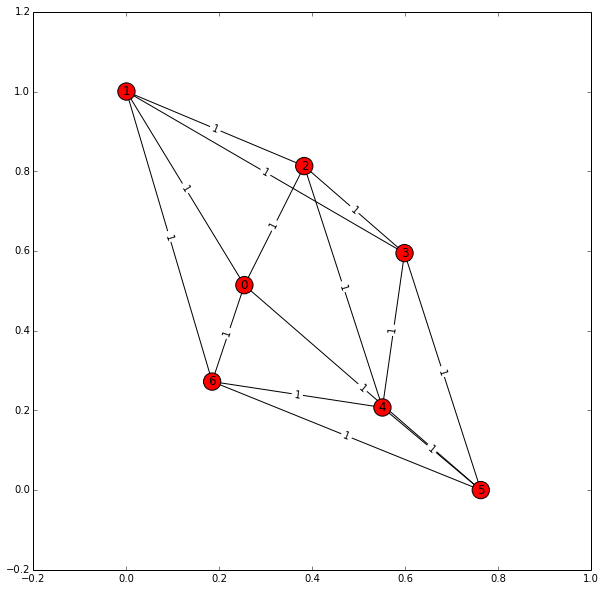

ER graph, p=0.3


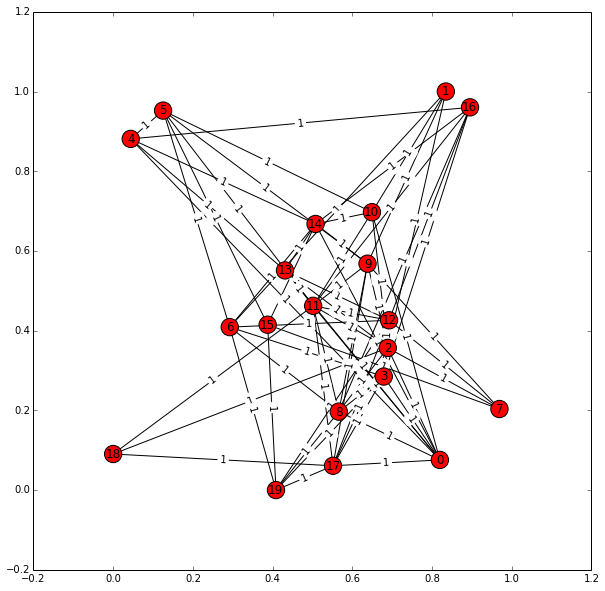

Powerlaw tree, gamma= 3


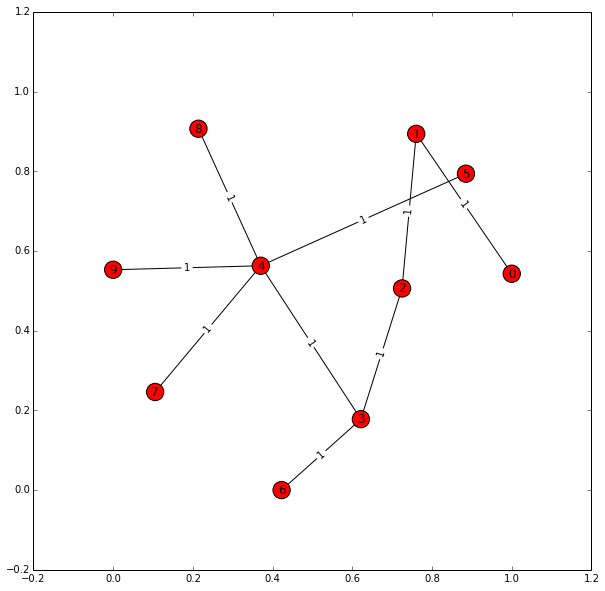

In [41]:
#Quick test of all graph generators
print "Watts Strogatz Ring (no rewiring)"
WS1 = get_watts_strogatz_graph(7,4,0.0)
draw_graph_helper(WS1,"spring")
print "ER graph, p=0.3"
draw_graph_helper(get_undirected_ER_graph(20,0.3),"spring")
print "Powerlaw tree, gamma= 3"
PLTREE1 = get_powerlaw_tree_graph(10,3)
draw_graph_helper(PLTREE1,"spring")



In [50]:
#Construct a graph whose edge weights are the likelihood of an awareness relationship, given the contact graph G
#under the JS spline metric model
# --> This is a symetric measure,for unweighted graphs 
def construct_awareness_from_contact_graph(G):
    H = G.copy()
    #print "Edges",H.edges()
    for pair in comb(G.nodes(),2): #get pairs
        x = pair[0]
        y = pair[1]
       
        metric = 0.0
        if (y in G[x].keys()):#if y a neighor of x (and visa versa)
            metric = 0.5
            
        #JS Metric
        xNbr = set(G[x])
        yNbr = set(G[y])
        
        #if they have no mutual neighbors
        if (len(xNbr) == 0 and len(yNbr) == 0):
            H.add_edge(x,y,weight=metric)
            continue
            
        mutualNbrs = xNbr.intersection(yNbr)
        
        #special case of isolated dyad
        if (xNbr == set([y]) and yNbr == set([x])):
            metric = 1.0
        else:
            metric = metric + len(mutualNbrs)/float(len(xNbr.union(yNbr)))
        
        #set as edge weight in new graph
        if (y not in H[x]):
            H.add_edge(x,y)
        H[x][y]['weight'] = metric
        
    return H
        
    

In [51]:
#Calculate the expected number of neighbors of S in nodeSet, not including S itself
def get_exp_coverage(G,nodeSet,S):
    #Coverage probabilities of
    #print "Finding coverage of S = ",S
    covg = {}
    
    for n in S:
        #Get neighbors
        for b in G[n]:
            #If not in nodeSet or in S, ignore
            if (b not in nodeSet or b in S):
                continue
            #If in nodeSet and already covered by some node, update coverage
            elif (b in covg.keys()): 
                #Update coverage of b
                covg[b] = 1 - (1-covg[b])*(1-G[n][b]['weight'])
            else:
                covg[b] = G[n][b]['weight']
                
    #return the sum of all of the coverage weights
    return sum([covg[x] for x in covg.keys()])
    
# Find approximation max coverage set using k-greedy method, with t total nodes in solution
def greedy_expected_max_coverage_set(G,t,k):
    #Debug
    assert(t < len(G.nodes()))
    
        #solution
    soln = set()
           
    #node set
    remaining_nodes = set(G.nodes())
    
    #Construct how many nodes to select at each step
    k_vals = [k for _ in range(int(math.floor(float(t)/k)))]
    if (t - sum(k_vals) > 0):
        k_vals.append(t - sum(k_vals))
    #Debug
    assert(sum(k_vals) == t)
    
    for sub_k in k_vals:
        
        #Get value of current (partial solution)
        if (len(soln) > 0):
            current_covg = get_exp_coverage(G,G.nodes(),soln)
        else:
            current_covg = 0.0
           
        max_sym_diff = 0.0
        best_seen_soln = set()
        remaining_nodes = remaining_nodes.difference(soln)
        
        #print "\n Selecting next ", sub_k, "nodes from set ", remaining_nodes
        for nodeset in comb(remaining_nodes,sub_k): #For all k combinations of unselected nodes
            #calculate expected coverage with the addition of nodeset to the current solution
            sym_diff = get_exp_coverage(G,G.nodes(),soln.union(nodeset))
            #print "Coverage of ", soln.union(nodeset), "is ", sym_diff
            if (sym_diff > max_sym_diff):
                #print "Using ", nodeset, "as current best"
                max_sym_diff = sym_diff
                best_seen_soln = nodeset
        #print "Chose node(s) ", list(best_seen_soln)
        #Add found nodes to solution set
        #Debug
        assert(len(set(best_seen_soln).intersection(soln)) == 0)
        soln = soln.union(set(best_seen_soln))
        
    #Return coverage plus the number of committee members
    return soln,(max_sym_diff+t)

In [52]:
#sanity test of coverage max algorithm
PLTREE1_AWARENESS = construct_awareness_from_contact_graph(PLTREE1)
print "Power law tree awareness graph"
draw_graph_helper(PLTREE1_AWARENESS)

print "Watts strogatz (no rewire) awareness graph"
WS1_AWARENESS = construct_awareness_from_contact_graph(WS1)
draw_graph_helper(WS1_AWARENESS)


NameError: name 'PLTREE1' is not defined

In [53]:
S1 = greedy_expected_max_coverage_set(PLTREE1_AWARENESS,1,1)
print "One node soln",S1

S2 = greedy_expected_max_coverage_set(PLTREE1_AWARENESS,2,1)
print "Two node soln, greedy",S2

S3 = greedy_expected_max_coverage_set(PLTREE1_AWARENESS,2,1)
print "Two node soln, opt", S3

draw_graph_helper(PLTREE1,"spring")

draw_graph_helper(PLTREE1_AWARENESS,"spring")




NameError: name 'PLTREE1_AWARENESS' is not defined

In [54]:
S0 = greedy_expected_max_coverage_set(WS1,2,1)
print "Two node soln to watts strogatz contact greedy",S0

S1 = greedy_expected_max_coverage_set(WS1,2,2)
print "Two node soln to watts strogatz contact opt",S1

S2 = greedy_expected_max_coverage_set(WS1_AWARENESS,2,1)
print "Two node soln to WS awareness greedy",S2

S3 = greedy_expected_max_coverage_set(WS1_AWARENESS,2,2)
print "Two node soln to WS awareness opt",S3

draw_graph_helper(WS1,"spring")

draw_graph_helper(WS1_AWARENESS,"spring")



NameError: name 'WS1' is not defined

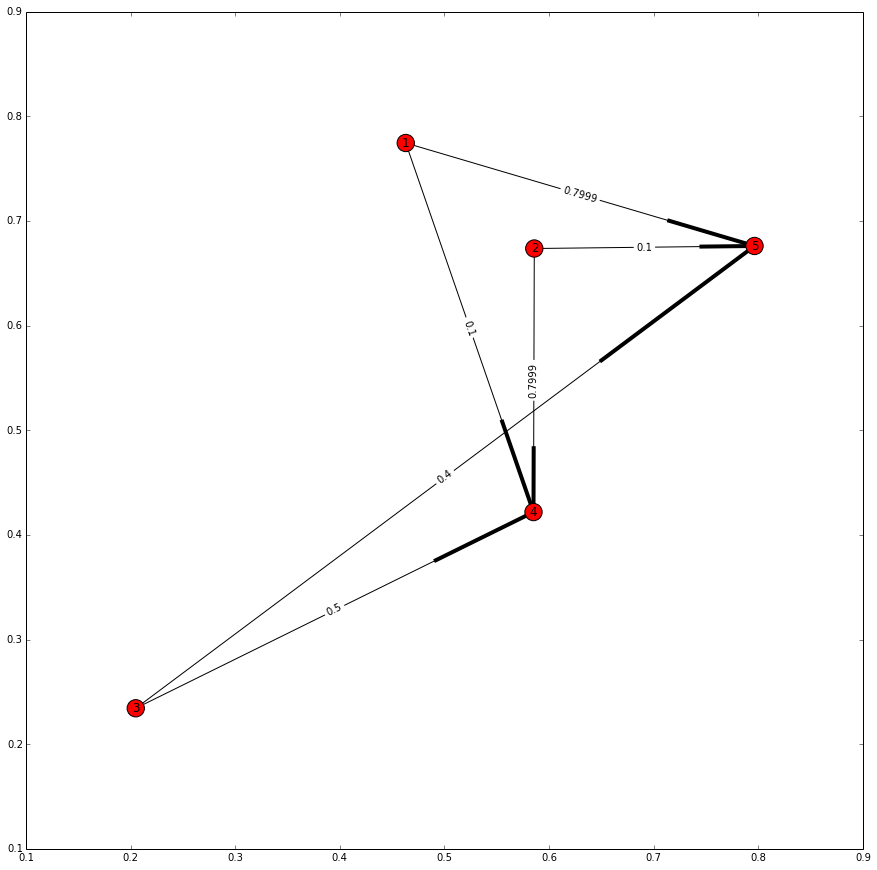

Expected coverage toy example, opt
(set([1, 2]), 3.6398200000000003)
**

Expected coverage toy example, greedy (will choose non-opt due to non-robustness to small differences)
(set([1, 3]), 3.42994)


In [55]:
#another sanity test

G = nx.DiGraph()
G.add_edge(1,4,weight=.1)
G.add_edge(1,5,weight=.7999)
G.add_edge(2,4,weight=.7999)
G.add_edge(2,5,weight=.1)
G.add_edge(3,4,weight=.5)
G.add_edge(3,5,weight=.4)

draw_graph_helper(G,"random")

print "Expected coverage toy example, opt"
print greedy_expected_max_coverage_set(G,2,2)

print "**\n\nExpected coverage toy example, greedy (will choose non-opt due to non-robustness to small differences)"
print greedy_expected_max_coverage_set(G,2,1)


In [56]:
"""
#Given a contact graph G and a committee, form the clique subgraph of the committee and perform probabilistic triadic closure
#on all unclosed triads which include two committee members
def simple_committee_closure_augmentation(G,committee,closure_threshold):
    H = G.copy()
    
    for x,y in comb(committee,2):
        #add committee-committee edge
        H.add_edge(x,y,weight=1)
        
        #Close triads
        for n in set(G[x].keys()).union(G[y].keys()):
            
            if (n not in G[y]): #then unclosed triad, missing edge n-y
                r = rand.random()
                if (r<closure_threshold):
                    H.add_edge(n,y,weight=1)
            elif (y not in G[x]): #unclosed triad missing edge n-x
                r = rand.random()
                if (r<closure_threshold):
                    H.add_edge(n,x,weight=1)
                    
    return H
"""

def committee_closure_augmentation(G,committee,closure_threshold):
    H = G.copy()
    
    for x,y in comb(committee,2):
        #add committee-committee edge
        H.add_edge(x,y,weight=1.0)
        
        #Close triads which have two committee members
        for n in set(G[x].keys()).union(G[y].keys()).difference(set([x,y])):
            
            if (n not in G[y]): #then unclosed triad, missing edge n-y
                r = rand.random()
                if (r<closure_threshold):
                    H.add_edge(n,y,weight=1)
            elif (y not in G[x]): #unclosed triad missing edge n-x
                r = rand.random()
                if (r<closure_threshold):
                    H.add_edge(n,x,weight=1)
    
    #Close triads which have one committee member
    for x in committee:
        for y in set(G[x].keys()).difference(set(committee)):
            for z in set(G[y].keys()).difference(set(committee)):
                if (z not in G[x].keys()): #if unclosed triad
                    r = rand.random()
                    if (r<closure_threshold):
                        H.add_edge(n,x,weight=1.0)
    return H
    

In [66]:
#Plot distribution of times at which given network is covered at alpha fraction by k nodes
def get_distribution_coverage_time(G_init,k,alpha,closure_param,trials=100,max_tries=100,alg="greedy"):
    time_dist = []
    num_nodes = len(G_init.nodes())
    
    for t in range(trials):
        G = G_init.copy()
        
        tries = 0
        if (alg.startswith("greedy")):
            #Greedy coverage algorithm
            committee,covg = greedy_expected_max_coverage_set(construct_awareness_from_contact_graph(G),k,1)
            while (covg < alpha*num_nodes and tries < max_tries):
                G = committee_closure_augmentation(G,committee,closure_param)
                print "T=%i" % (tries+1)
                draw_graph_helper(G,"spring")
                
                tries += 1
                committee,covg = greedy_expected_max_coverage_set(construct_awareness_from_contact_graph(G),k,1)
                
        elif (alg.startswith("random")):
            #Greedy coverage algorithm
            
            committee = np.random.choice(G.nodes(),k)
            
            #ensure uniqueness
            while (len(committee) != len(set(committee))):
                 committee = np.random.choice(G.nodes(),k)
                    
            covg = get_exp_coverage(G,G.nodes(),np.random.choice(G.nodes(),k))
            
            while (covg < alpha*num_nodes and tries < max_tries):
                G = committee_closure_augmentation(G,committee,closure_param)
                #draw_graph_helper(G,"spring")
                tries += 1
                committee = np.random.choice(G.nodes(),k)
                #ensure uniqueness
                while (len(committee) != len(set(committee))):
                     committee = np.random.choice(G.nodes(),k)



        
        if (covg < alpha*(len(G.nodes()))):
            print "ERROR: Coverage was %f, not high enough after Max tries= %i exceeded" % (covg,max_tries)
        print "Finished at time ", tries, " with committee", committee, " with coverage ", covg
        time_dist.append(tries)
        
    return time_dist
    

Coverage minimum fraction 0.75, committee size 3 and closure prob 0.20
T=1


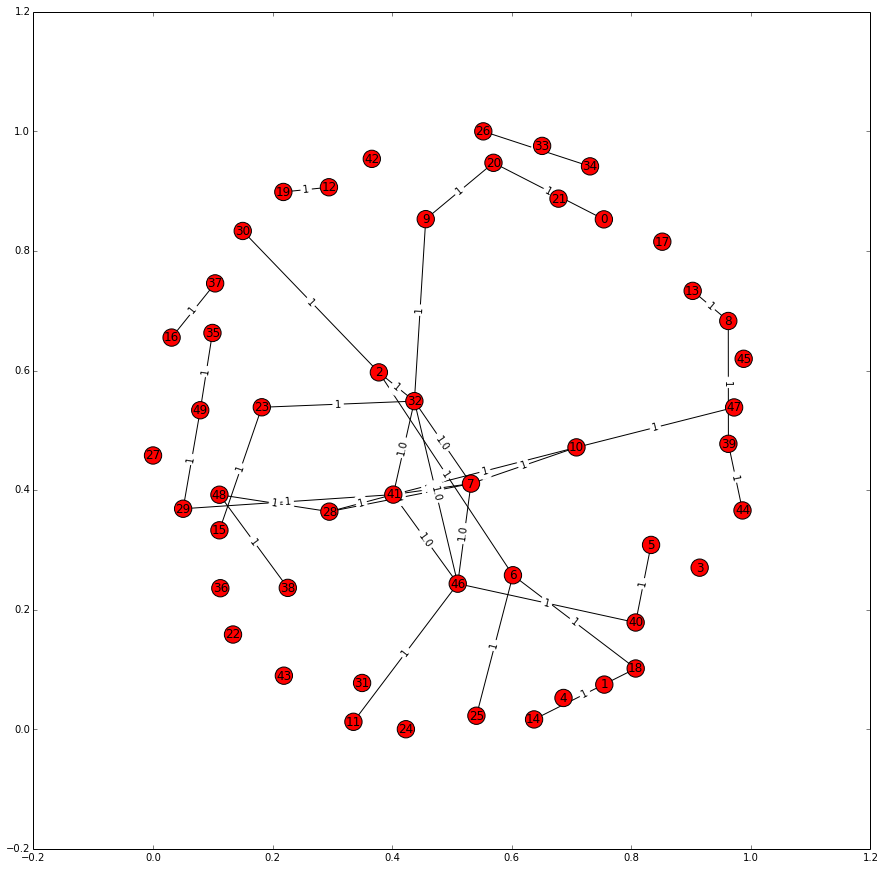

T=2


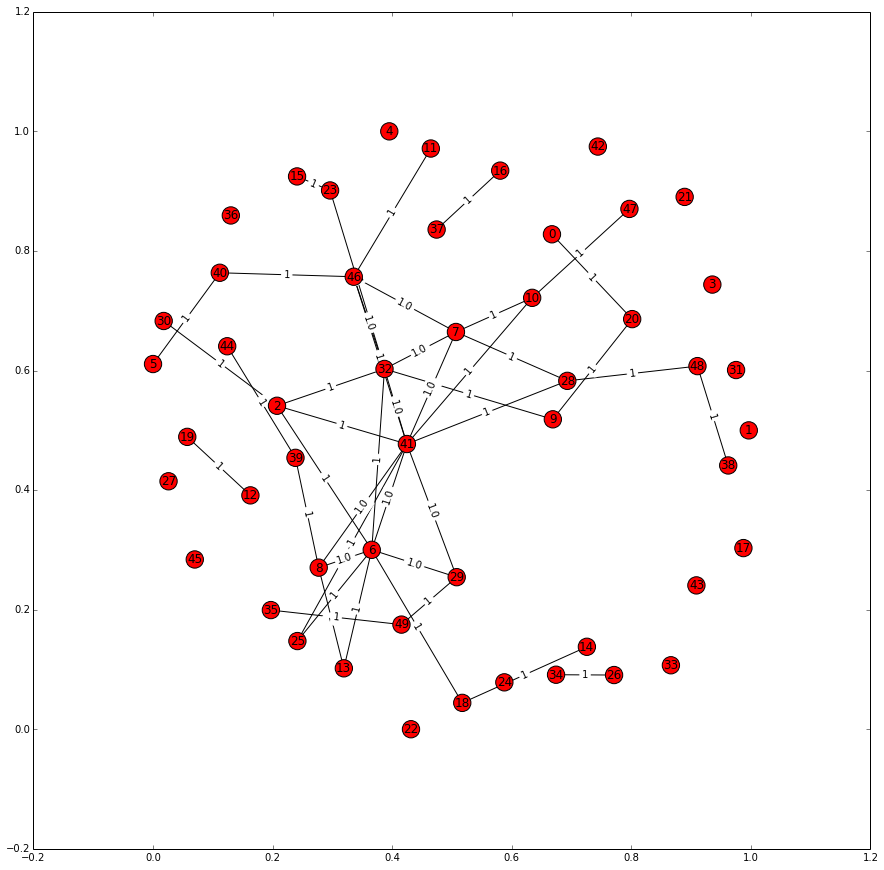

T=3


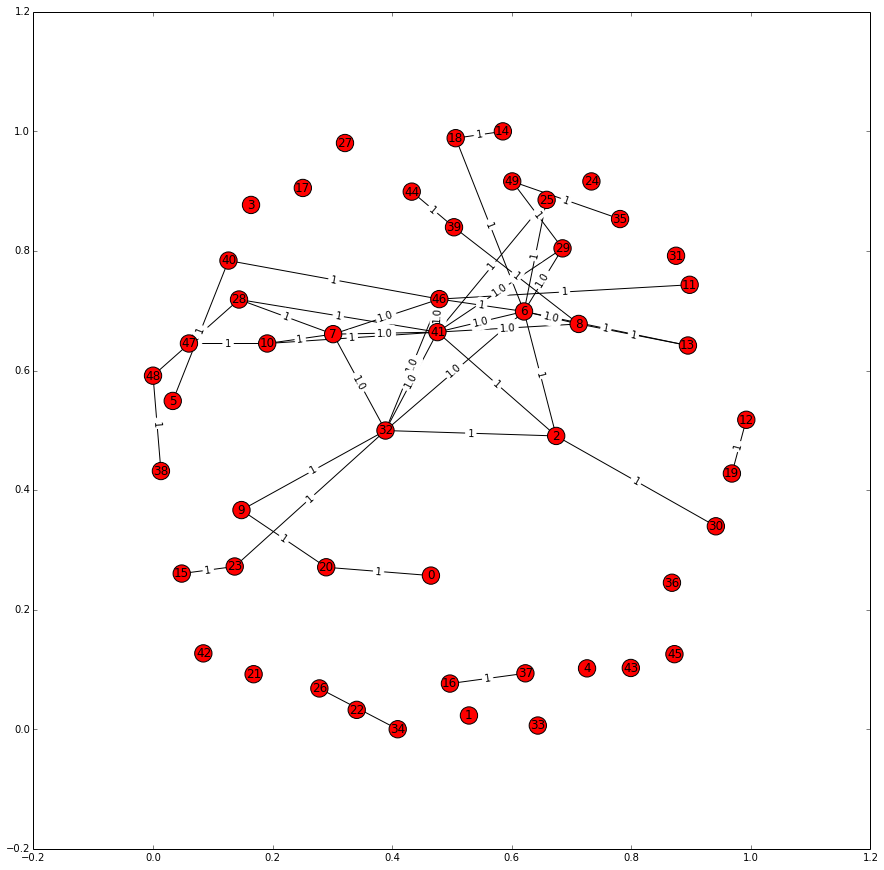

T=4


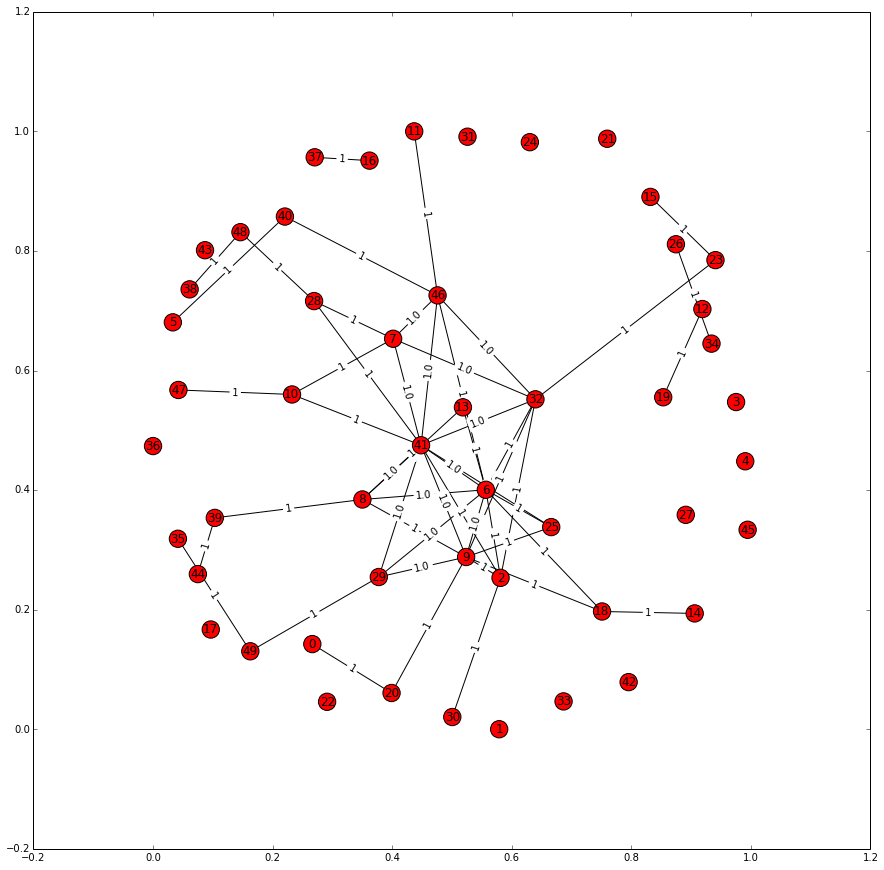

T=5


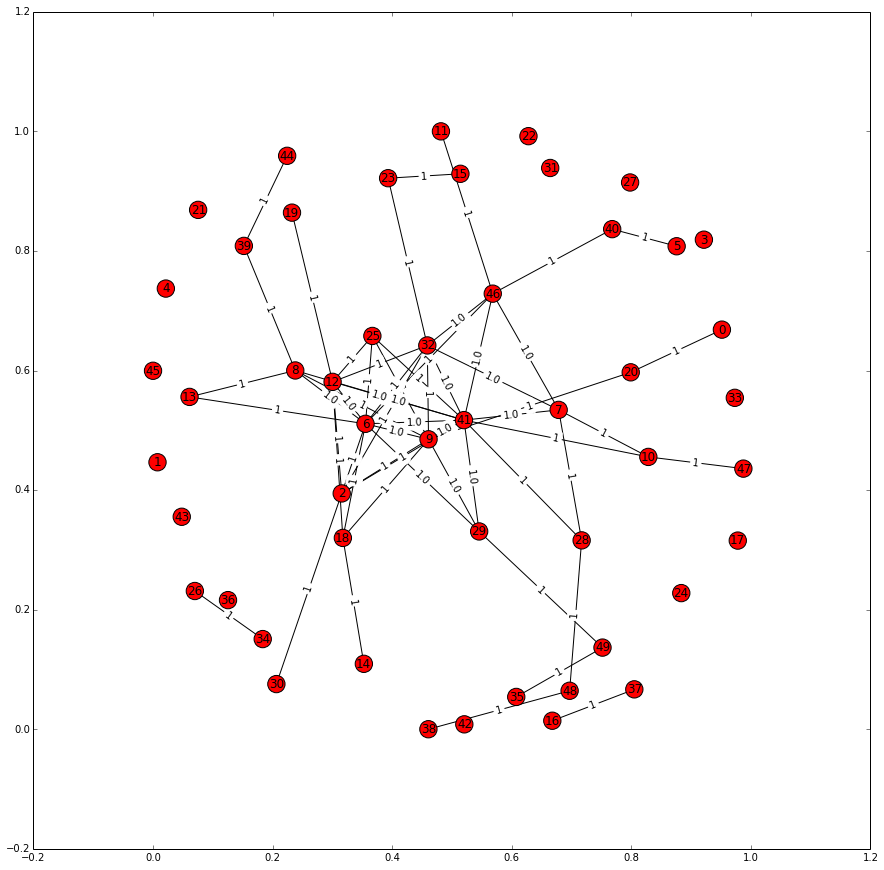

T=6


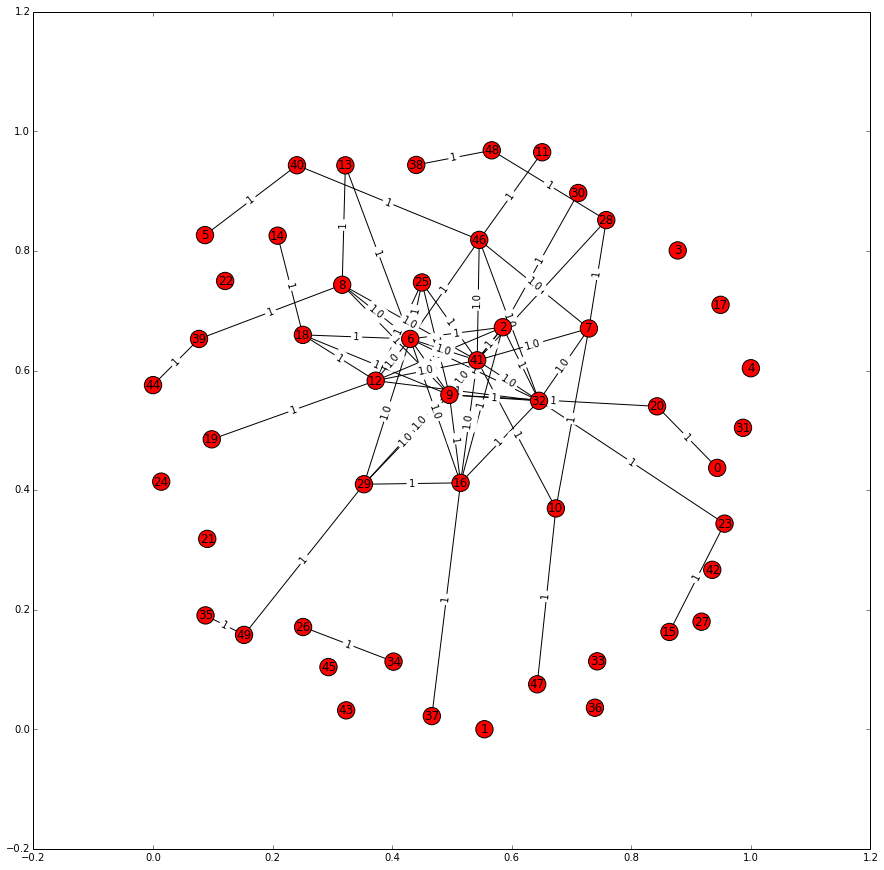

T=7


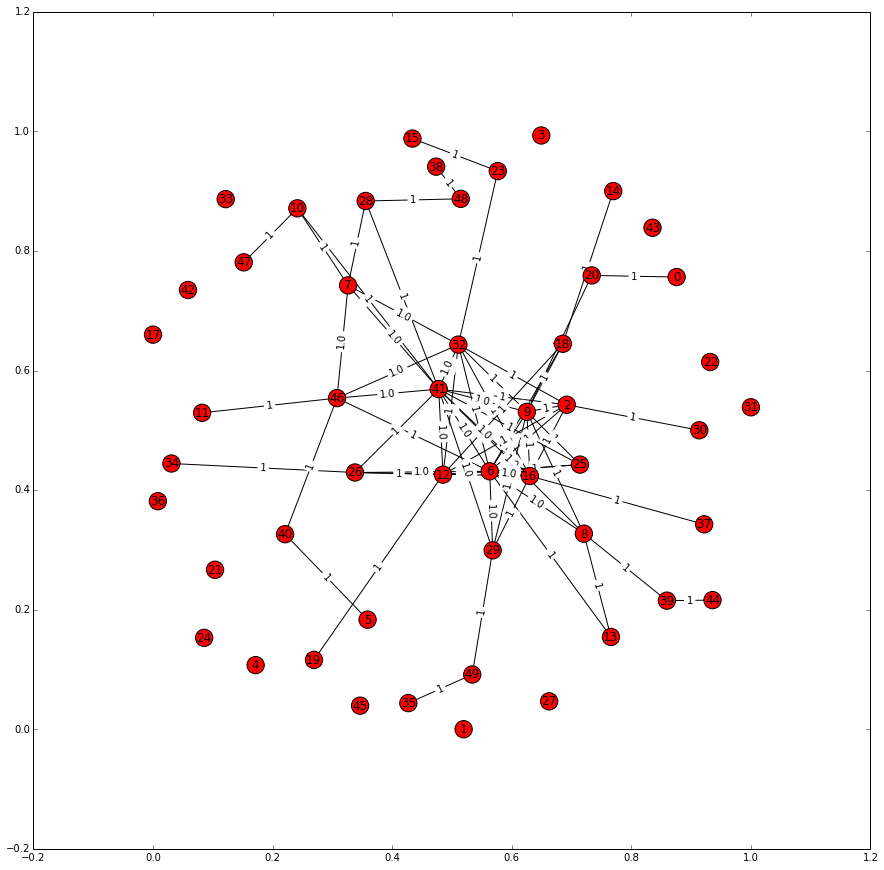

T=8


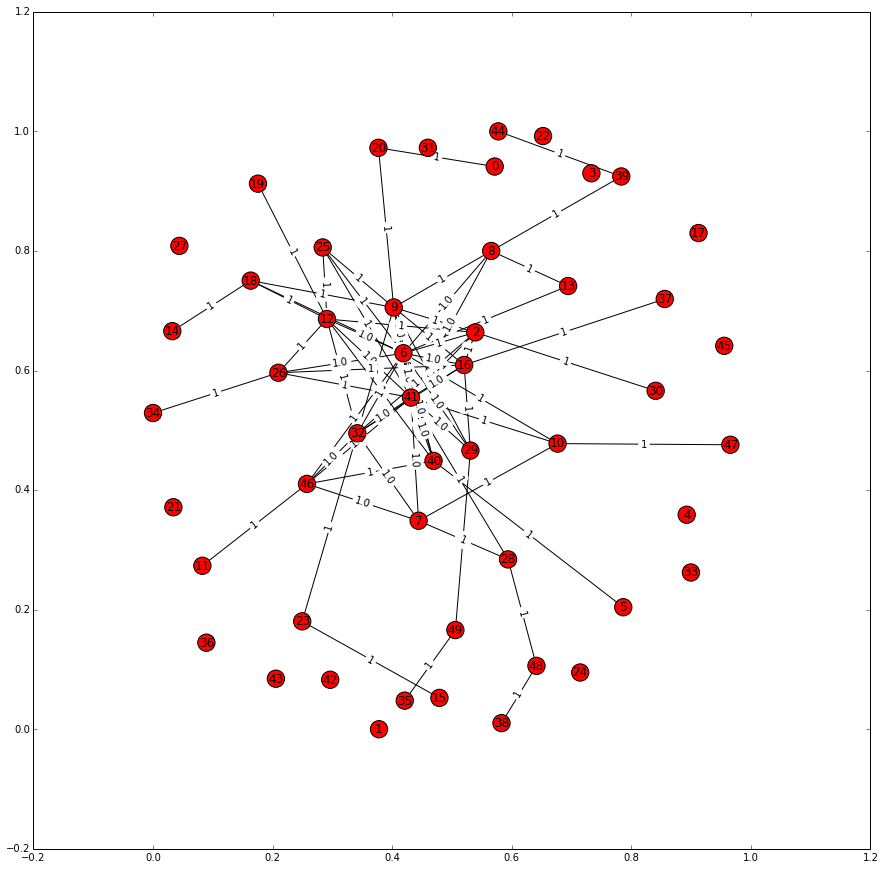

T=9


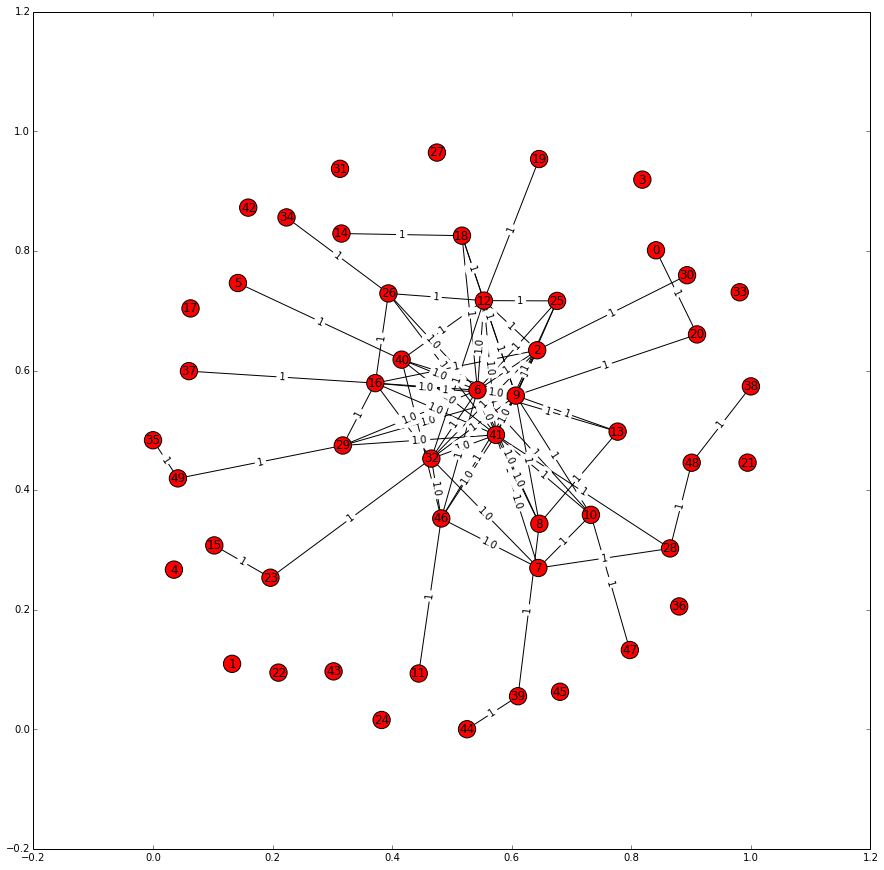

T=10


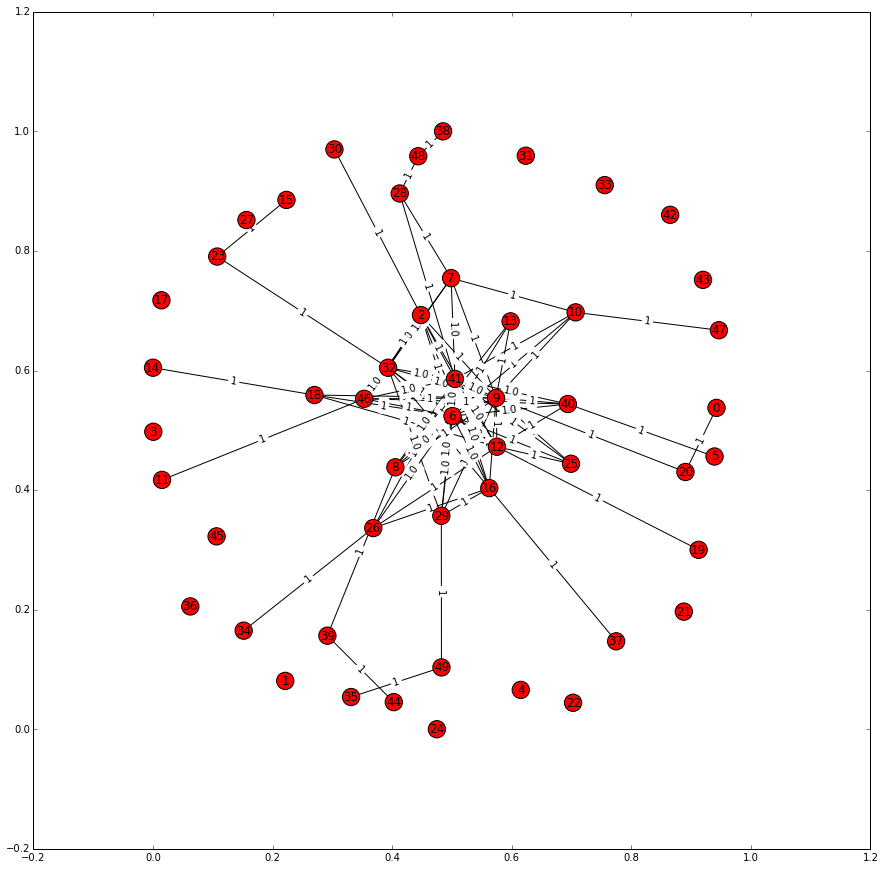

T=11


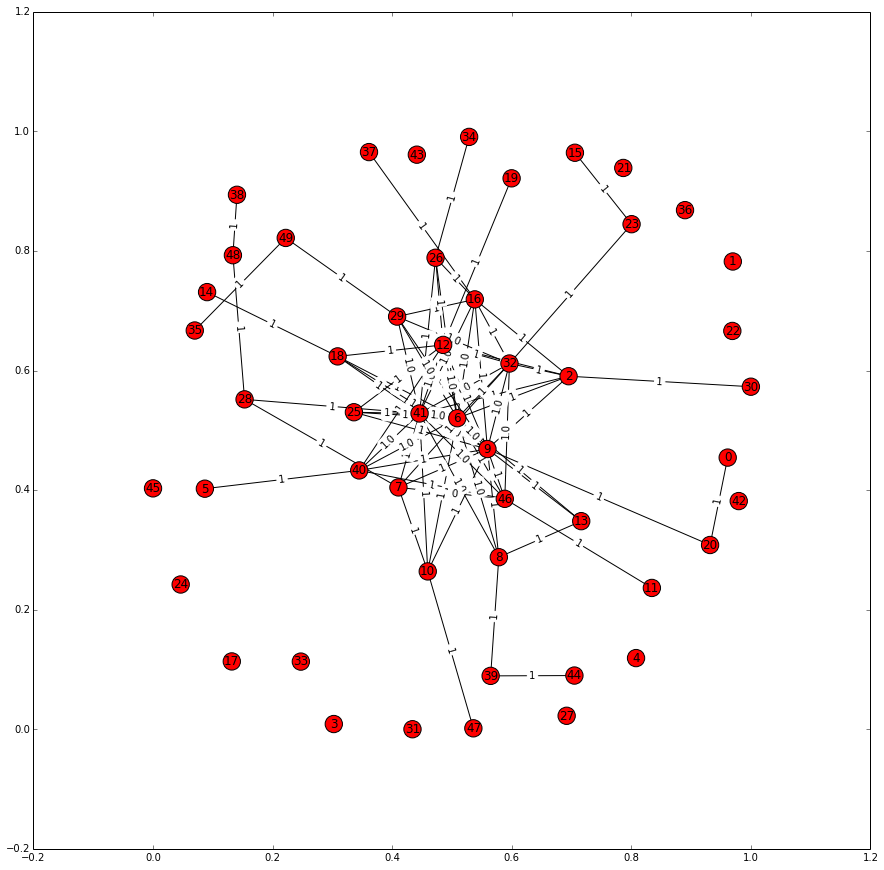

T=12


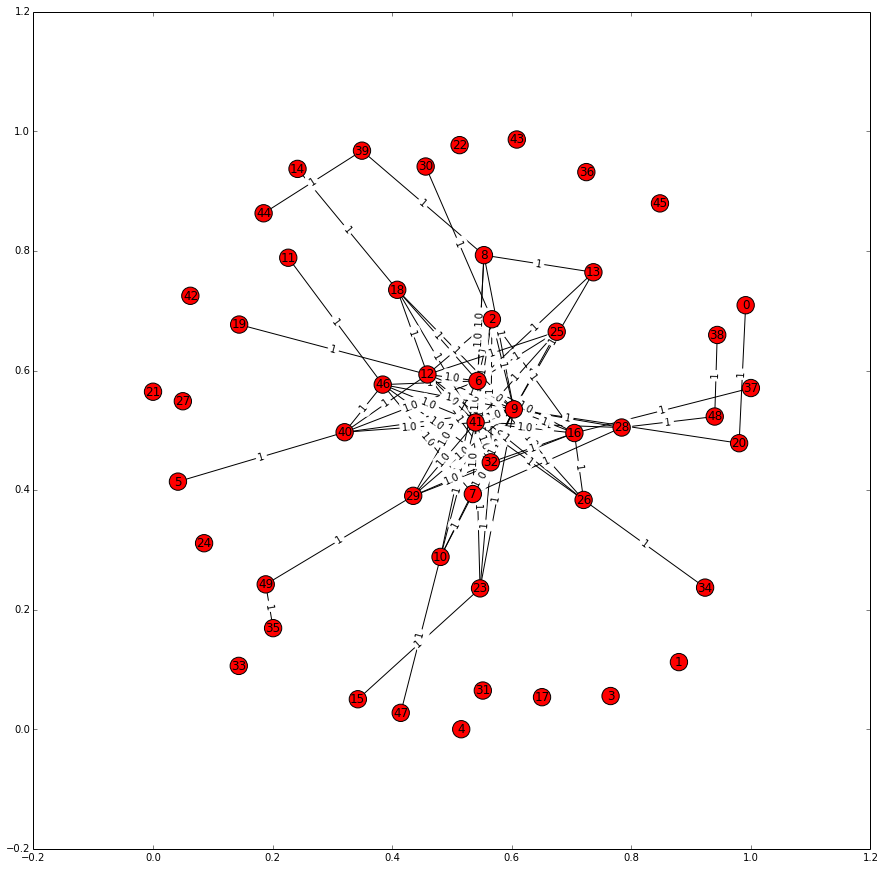

T=13


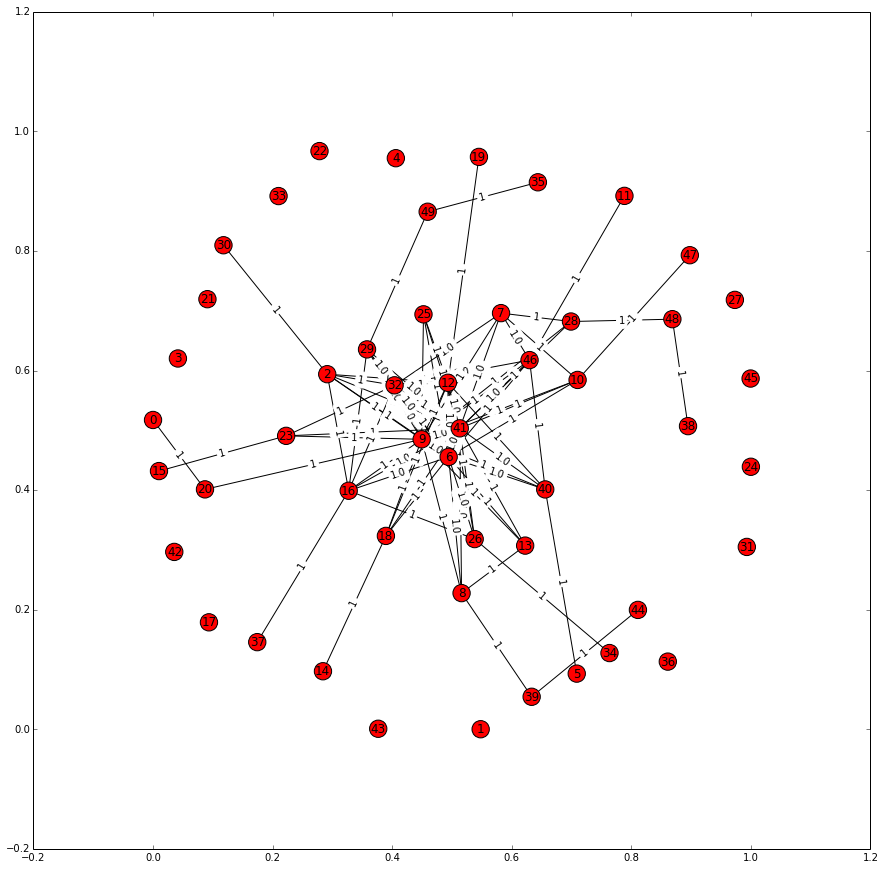

T=14


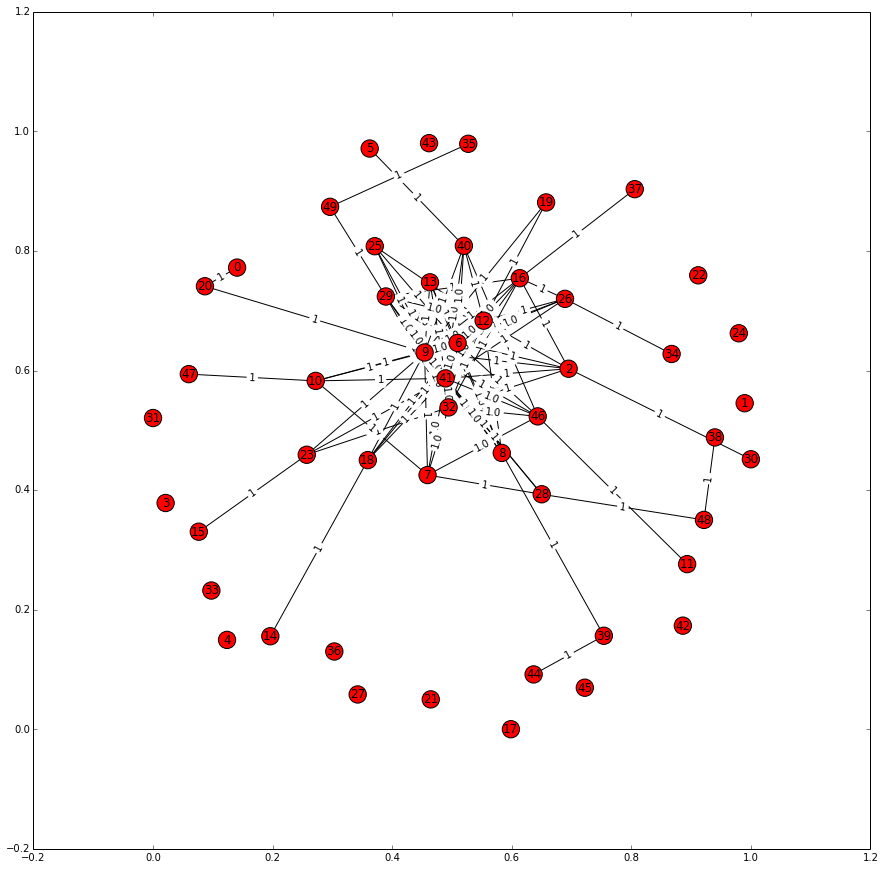

T=15


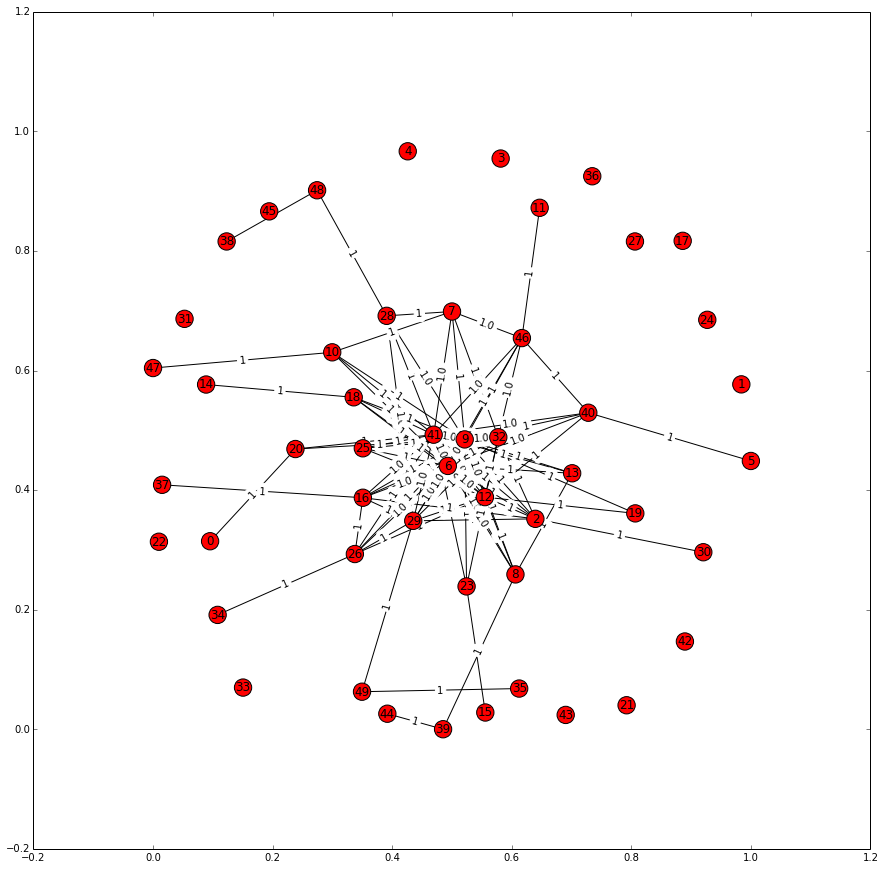

T=16


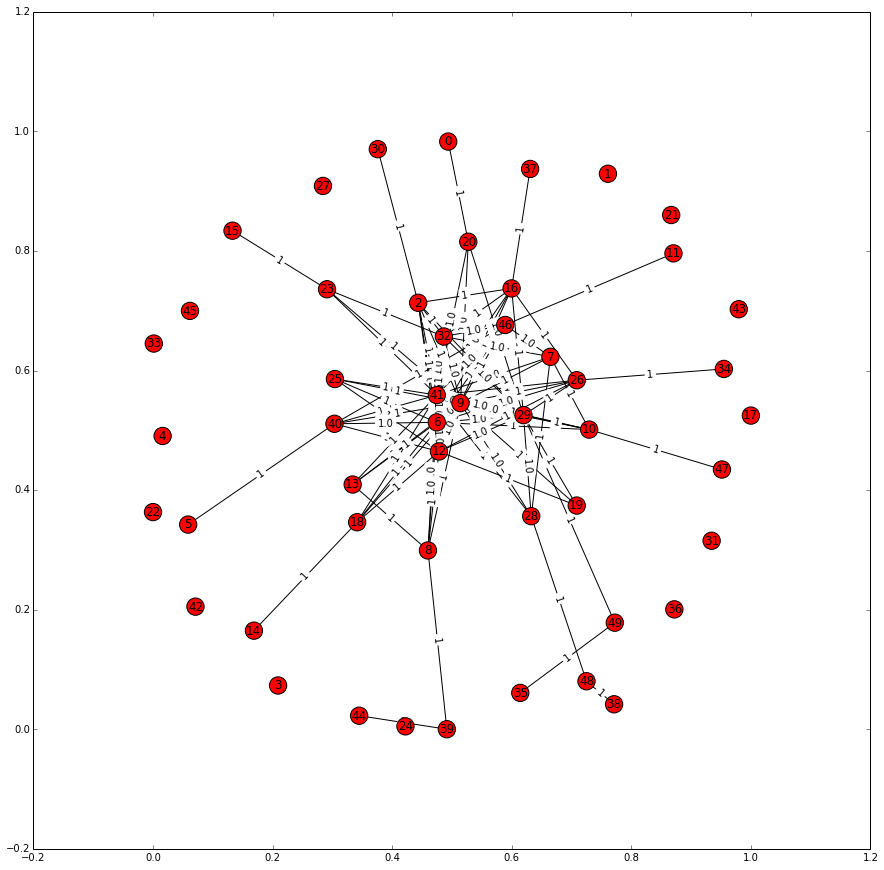

ERROR: Coverage was 22.190706, not high enough after Max tries= 16 exceeded
Finished at time  16  with committee set([9, 29, 41])  with coverage  22.1907055551
ERROR: Coverage was 1.000000, not high enough after Max tries= 16 exceeded
Finished at time  16  with committee [44  2 19]  with coverage  1


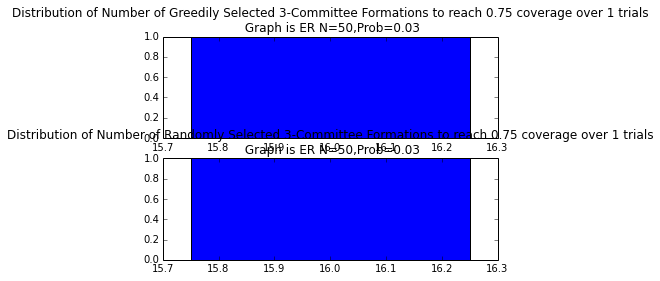

T=1


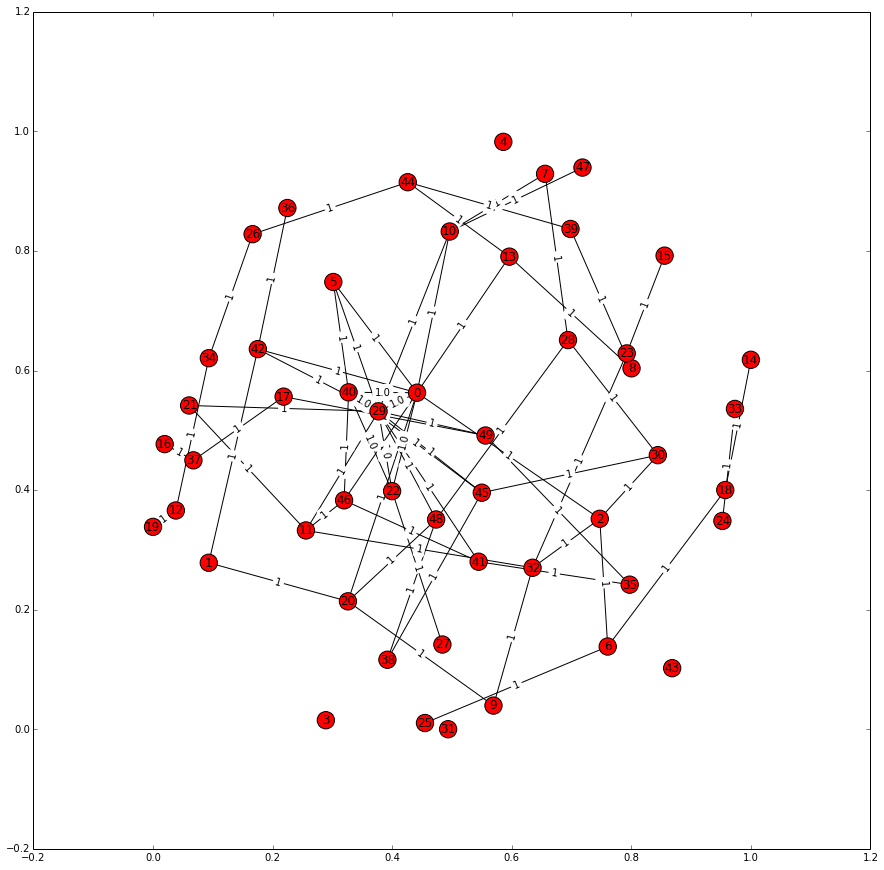

T=2


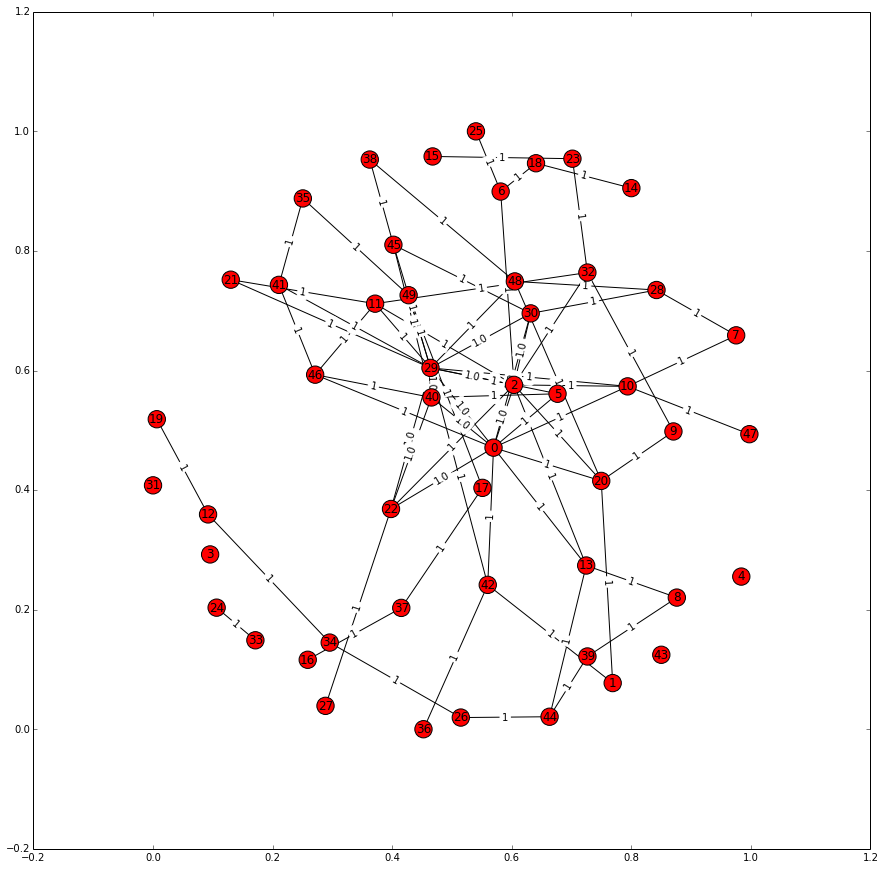

T=3


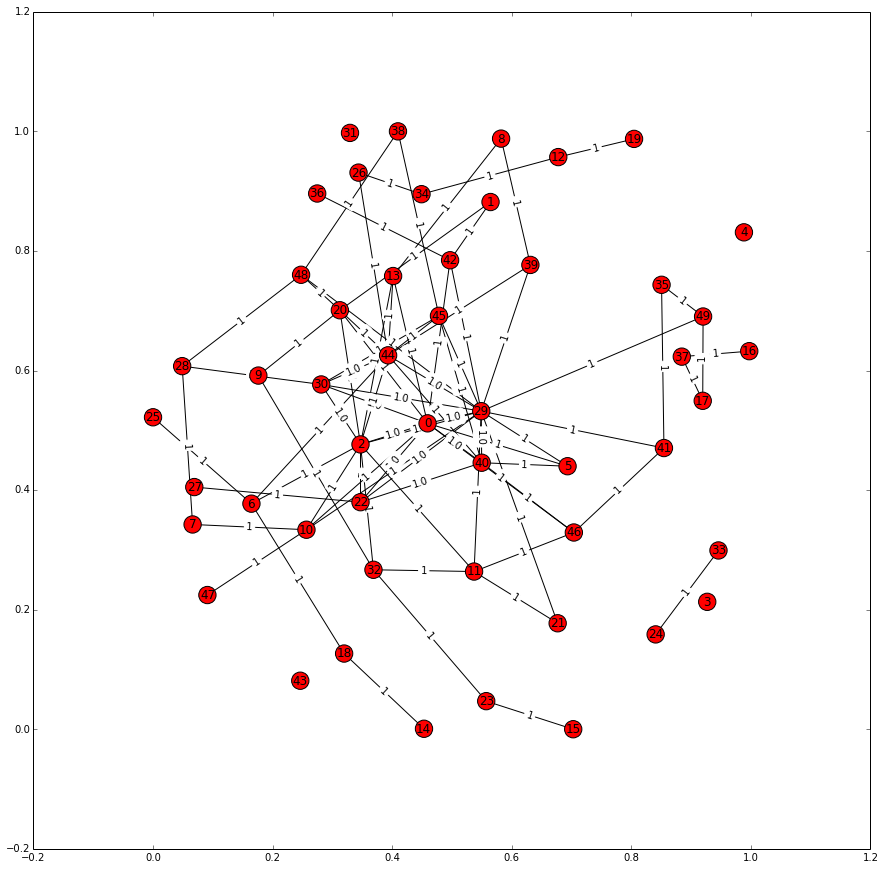

T=4


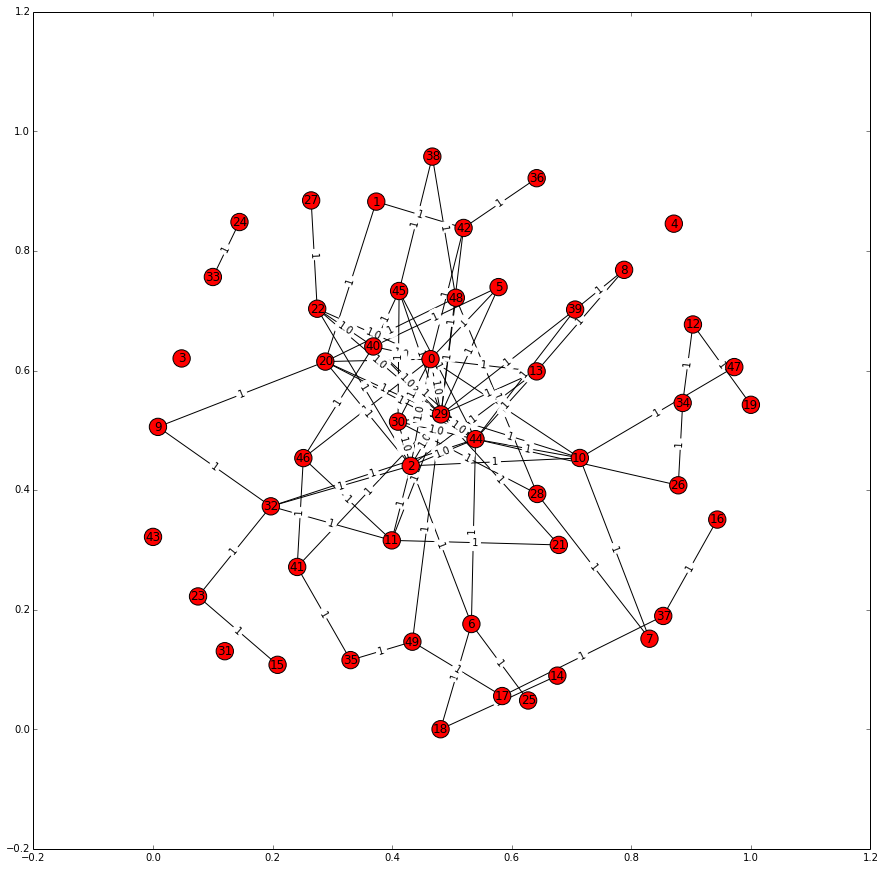

T=5


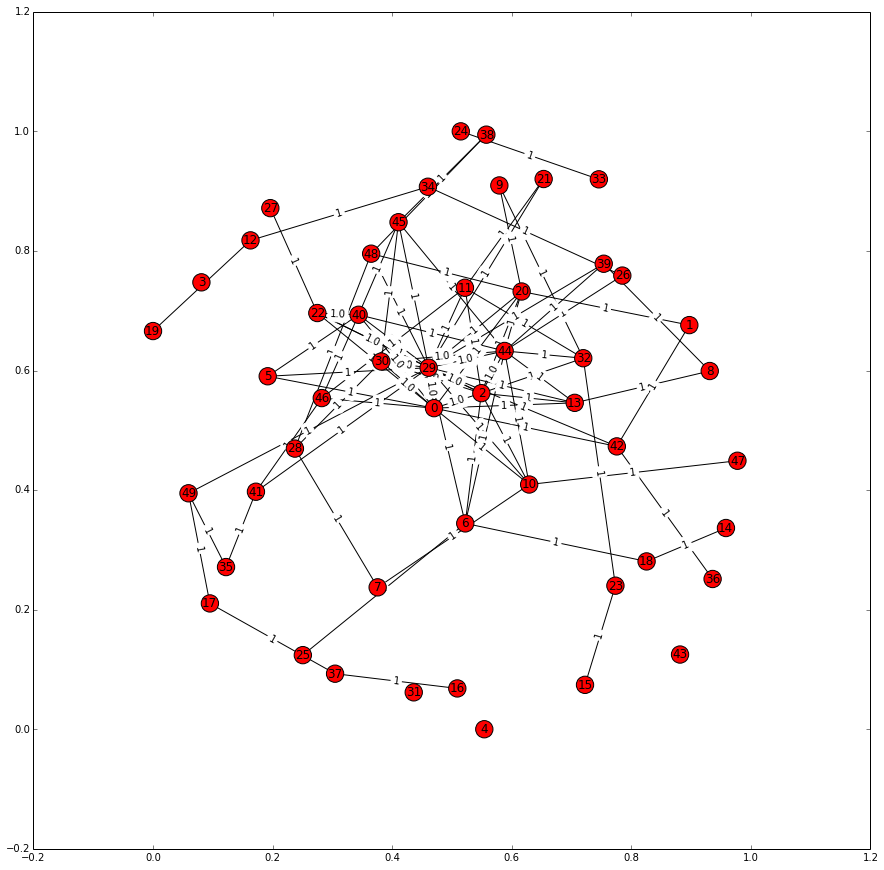

T=6


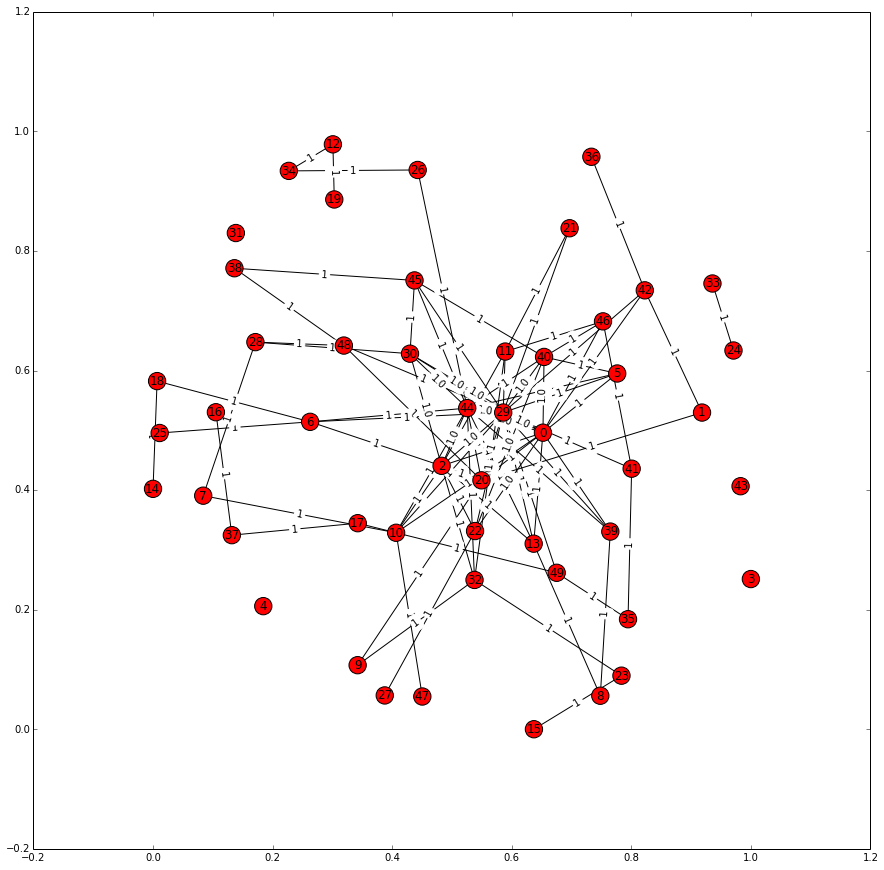

T=7


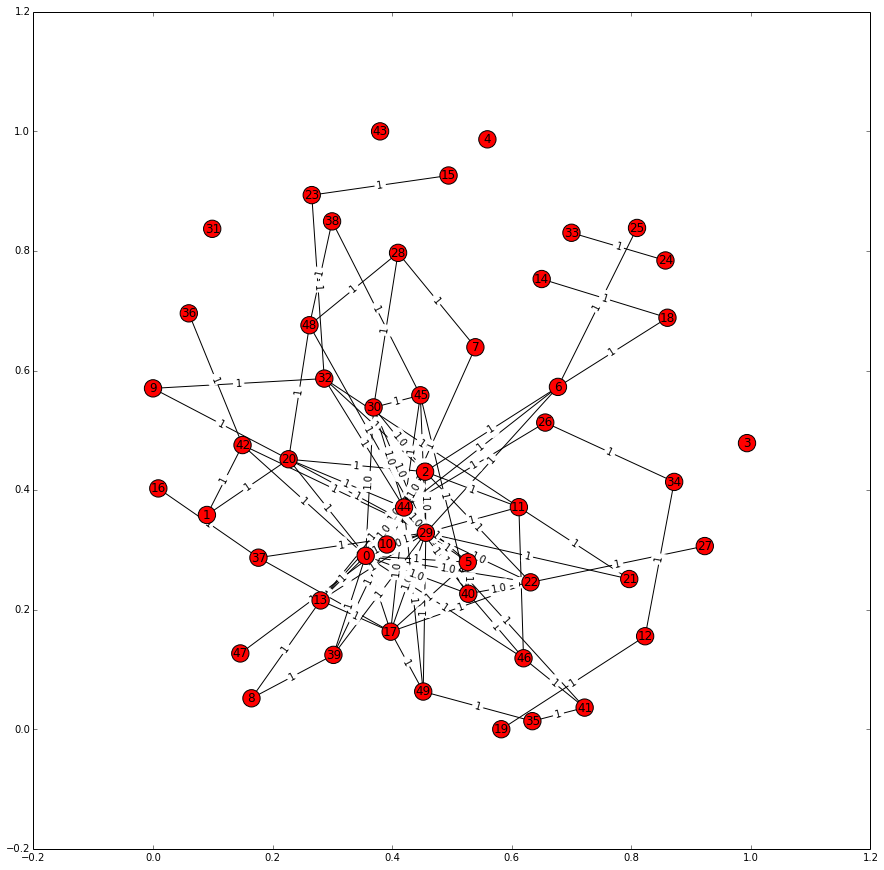

T=8


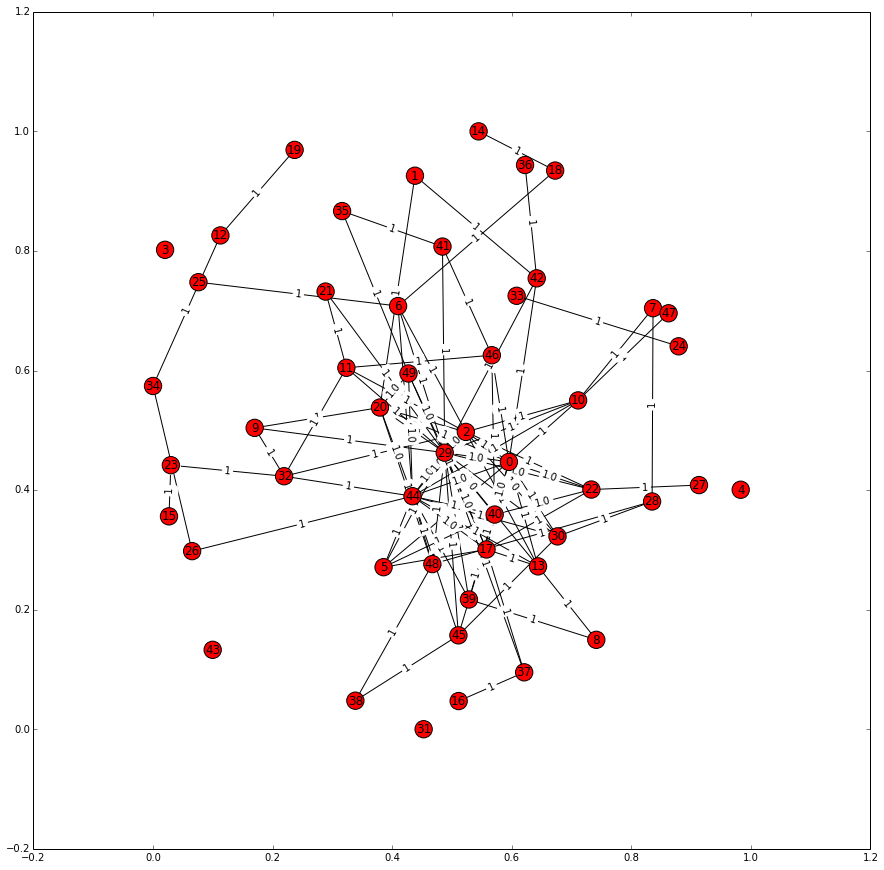

T=9


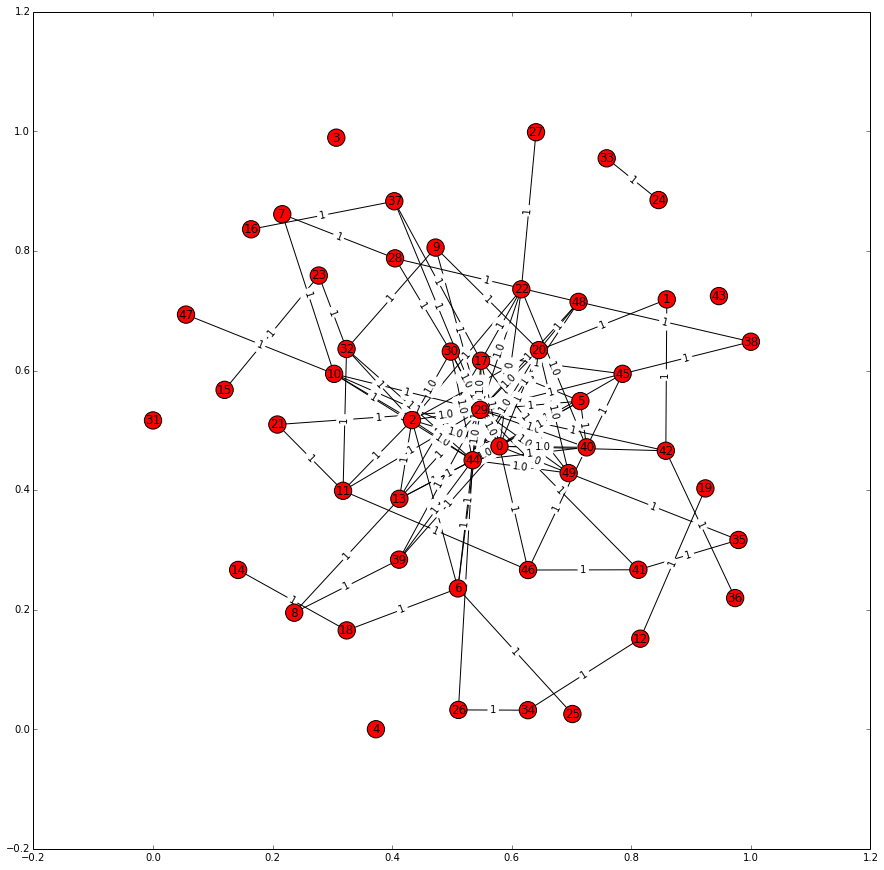

T=10


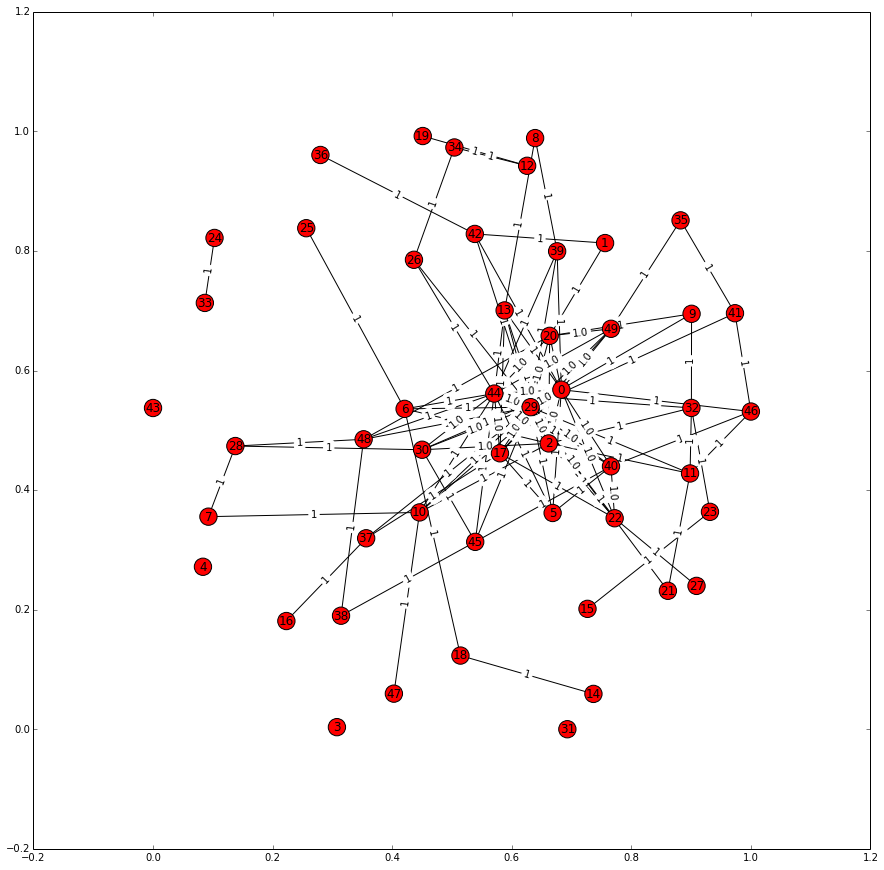

T=11


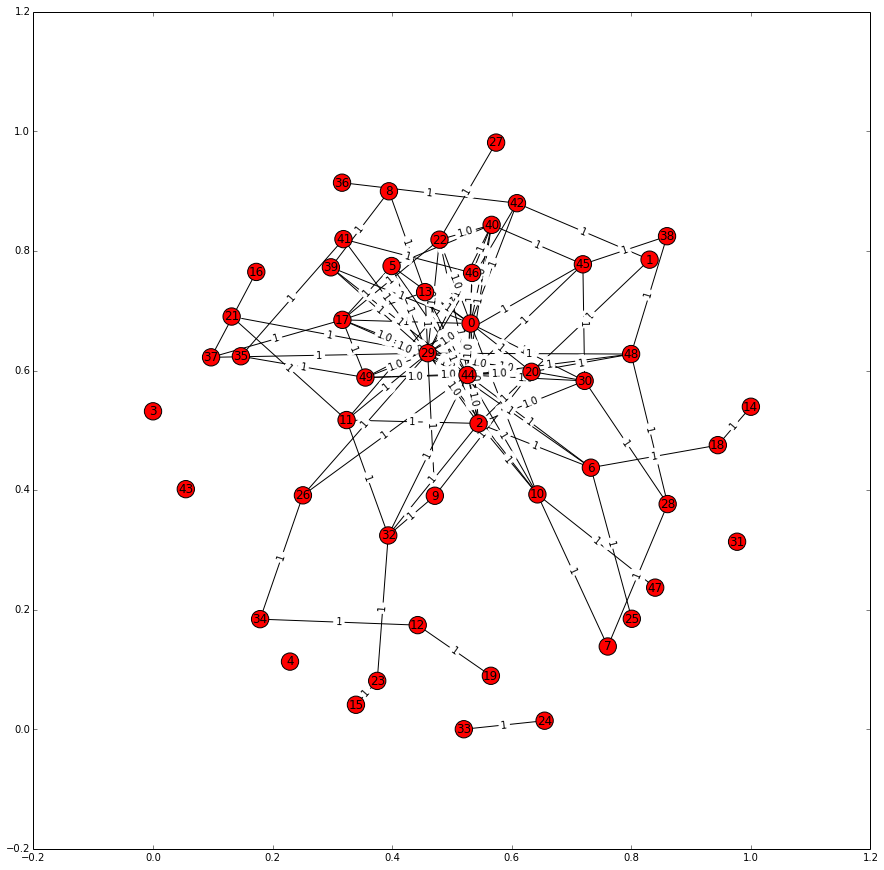

T=12


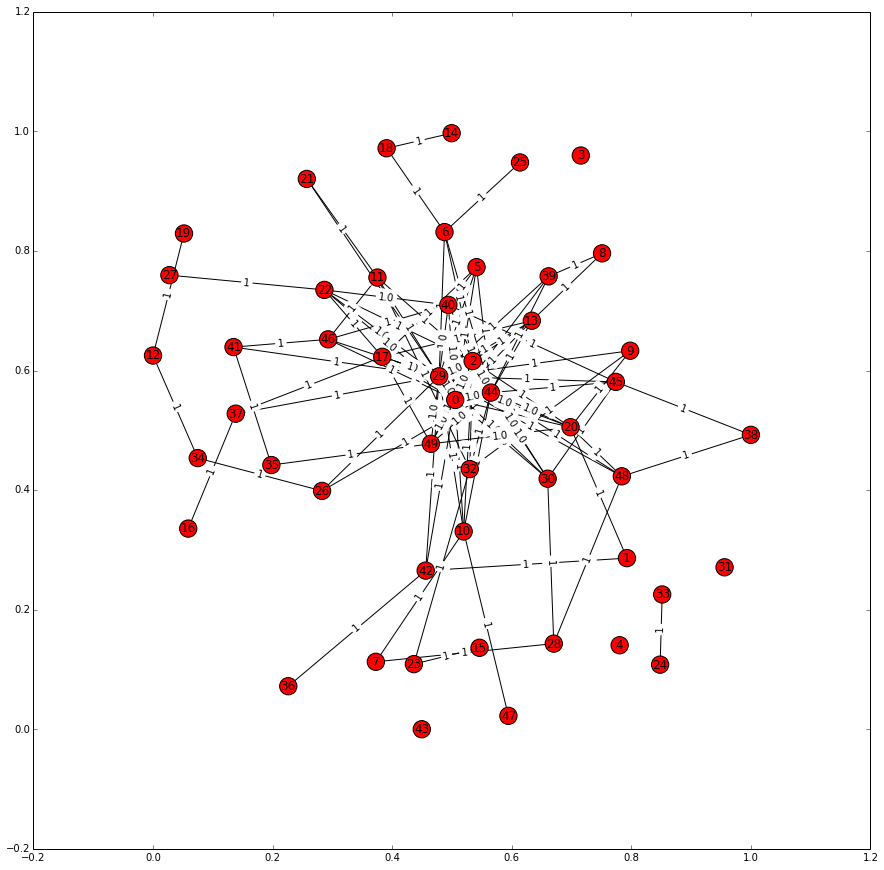

T=13


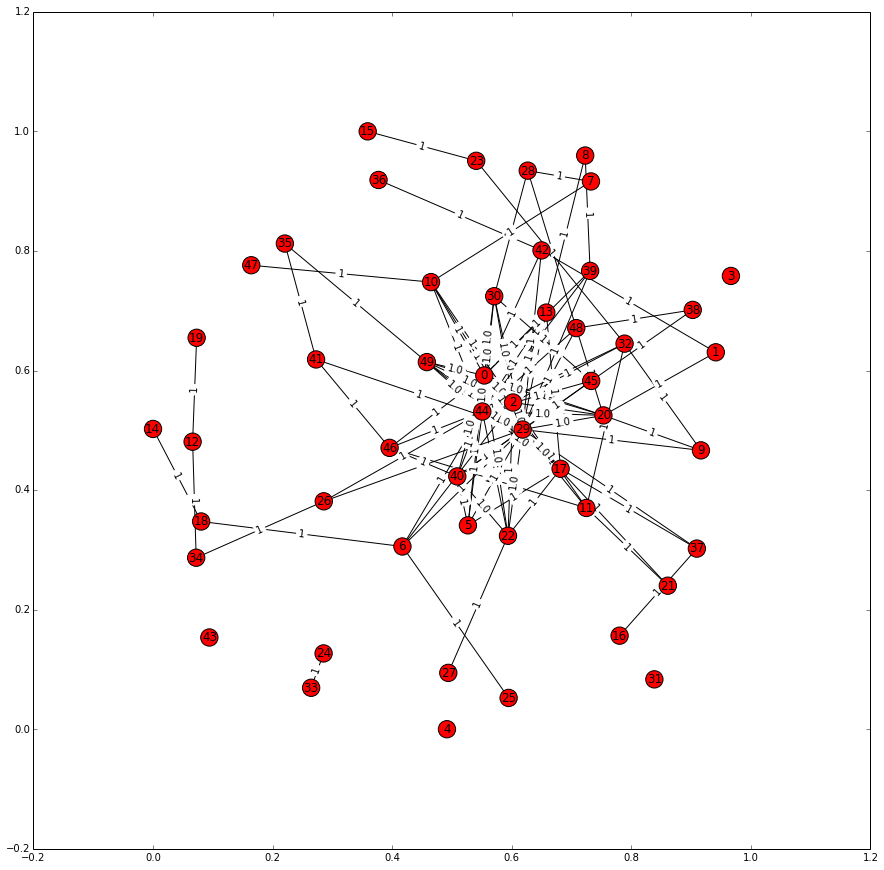

T=14


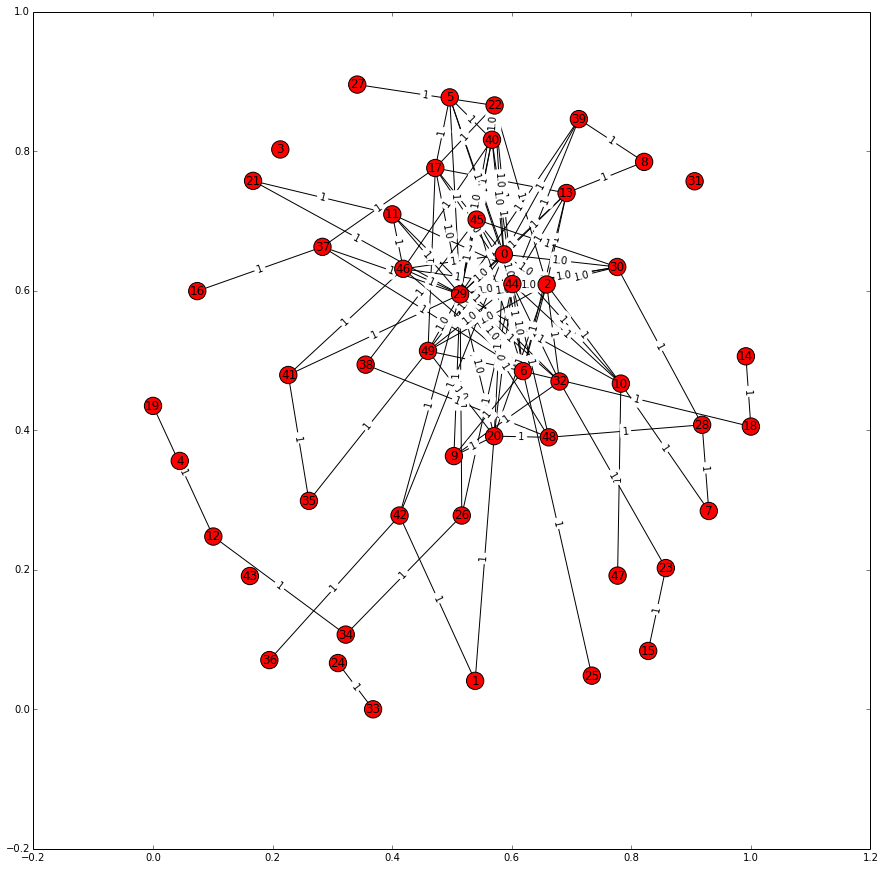

T=15


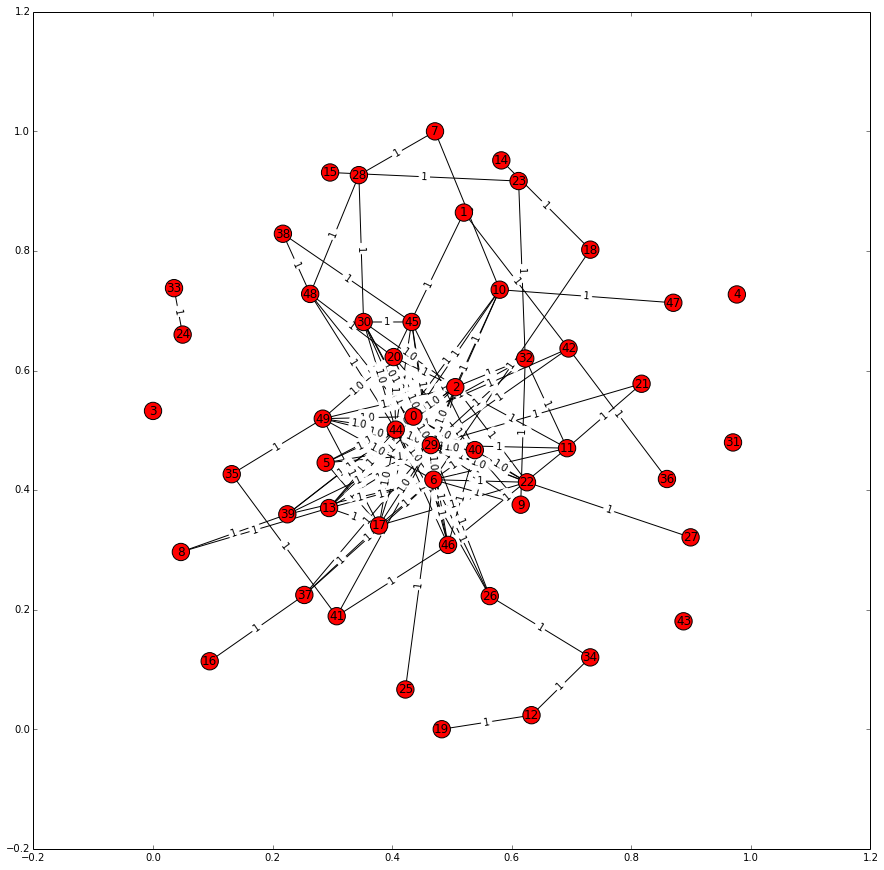

T=16


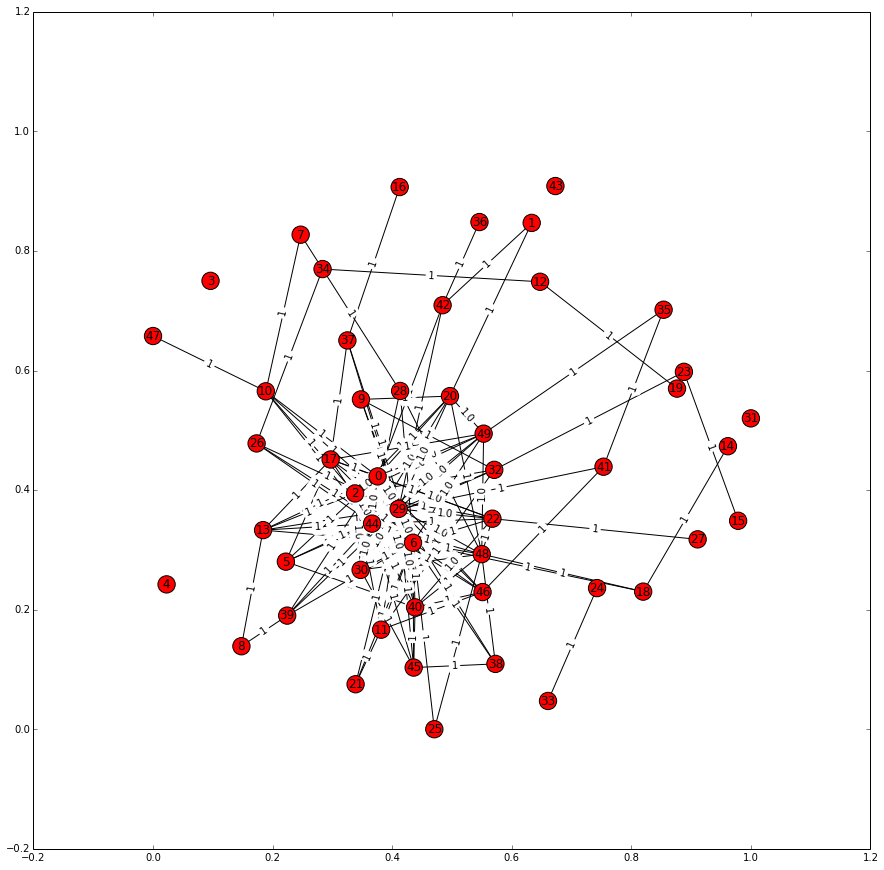

ERROR: Coverage was 28.107304, not high enough after Max tries= 16 exceeded
Finished at time  16  with committee set([44, 29, 6])  with coverage  28.1073037449
ERROR: Coverage was 6.000000, not high enough after Max tries= 16 exceeded
Finished at time  16  with committee [27 46 26]  with coverage  6


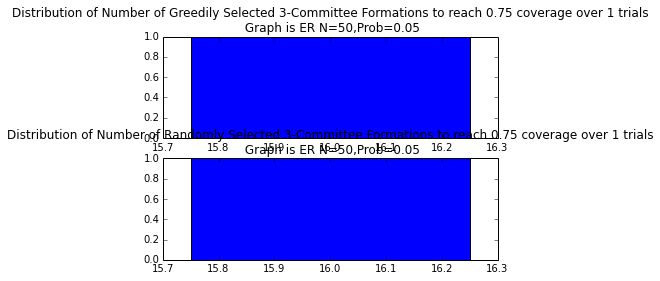

DONE


In [68]:
#Toy examples


COMMITTEE_SZ = 3

COVERAGE_MIN = 0.75
CLOSURE_PARAM = 0.20
trials = 1

G_list = []

#List of graphs to try
"""
N = 10
WS_K = 2
WS_P = 0.0
COMMITTEE_SZ = 3
G_list.append([get_watts_strogatz_graph(N,WS_K,WS_P),"Watts Strogatz N=%i,Deg=%i,Rewire Prob=%.2f" % (N,WS_K,WS_P),COMMITTEE_SZ])

N = 100
WS_K = 6
WS_P = 0.0
COMMITTEE_SZ = 6
G_list.append([get_watts_strogatz_graph(N,WS_K,WS_P),"Watts Strogatz N=%i,Deg=%i,Rewire Prob=%.2f" % (N,WS_K,WS_P),COMMITTEE_SZ])

N = 10
WS_K = 4
WS_P = 0.10
COMMITTEE_SZ = 3
G_list.append([get_watts_strogatz_graph(N,WS_K,WS_P),"Watts Strogatz N=%i,Deg=%i,Rewire Prob=%.2f" % (N,WS_K,WS_P),COMMITTEE_SZ])


N = 100
WS_K = 6
WS_P = 0.10
COMMITTEE_SZ = 6
G_list.append([get_watts_strogatz_graph(N,WS_K,WS_P),"Watts Strogatz N=%i,Deg=%i,Rewire Prob=%.2f" % (N,WS_K,WS_P),COMMITTEE_SZ])

N = 10
WS_K = 4
WS_P = 0.75
COMMITTEE_SZ = 3
G_list.append([get_watts_strogatz_graph(N,WS_K,WS_P),"Watts Strogatz N=%i,Deg=%i,Rewire Prob=%.2f" % (N,WS_K,WS_P),COMMITTEE_SZ])

N = 100
WS_K = 6
WS_P = 0.75
"""
N = 50
ER_P = .025
G_list.append([get_undirected_ER_graph(N,ER_P),"ER N=%i,Prob=%.2f" % (N,ER_P),COMMITTEE_SZ])

N = 50
ER_P = .05
G_list.append([get_undirected_ER_graph(N,ER_P),"ER N=%i,Prob=%.2f" % (N,ER_P),COMMITTEE_SZ])


#draw_graph_helper(G,"random")
#draw_graph_helper(G,"spring")
print "Coverage minimum fraction %.2f, committee size %i and closure prob %.2f" % (COVERAGE_MIN,COMMITTEE_SZ,CLOSURE_PARAM)
for G,name,committee_sz in G_list:
        
    data_greedy = get_distribution_coverage_time(G,COMMITTEE_SZ,COVERAGE_MIN,CLOSURE_PARAM,trials,max_tries=N/COMMITTEE_SZ,alg="greedy")
    data_rand = get_distribution_coverage_time(G,COMMITTEE_SZ,COVERAGE_MIN,CLOSURE_PARAM,trials,max_tries=N/COMMITTEE_SZ,alg="random")


    # Two subplots, the axes array is 1-d
    f, axarr = plt.subplots(2, sharey=True)
   
    binwidth=1
    #print data
    hist_greedy,bins_greedy = np.histogram(data_greedy,bins=range(min(data_greedy), max(data_greedy) + binwidth+1, binwidth))                                 
    width_greedy = 0.5 * (bins_greedy[1] - bins_greedy[0])
    center_greedy = (bins_greedy[:-1] + bins_greedy[1:]) / 2
    
    axarr[0].bar(center_greedy, hist_greedy, align='center', width=width_greedy)
    axarr[0].set_title("Distribution of Number of Greedily Selected %i-Committee Formations to reach %.2f coverage over %i trials \n Graph is %s" %(committee_sz,COVERAGE_MIN,trials,name))
    
    
    hist_rand,bins_rand = np.histogram(data_rand,bins=range(min(data_rand), max(data_rand) + binwidth+1, binwidth))                                 
    width_rand = 0.5 * (bins_rand[1] - bins_rand[0])
    center_rand = (bins_rand[:-1] + bins_rand[1:]) / 2
    
    axarr[1].bar(center_rand, hist_rand, align='center', width=width_rand)
    axarr[1].set_title("Distribution of Number of Randomly Selected %i-Committee Formations to reach %.2f coverage over %i trials \n Graph is %s" %(committee_sz,COVERAGE_MIN,trials,name))
    
    plt.show()
    
print "DONE"